In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random as rand
import os
from collections import Counter
from sklearn.linear_model import LogisticRegression

In [81]:
cd ../data

/Users/johnwalecka/Desktop/Springboard/march_madness/march_madness_repo/data


In [105]:
tourney_seeds = pd.read_csv('MNCAATourneySeeds.csv', index_col ='Season').loc['2015'].set_index('TeamID')
tourney_results = pd.read_csv('MNCAATourneyCompactResults.csv', index_col ='Season').loc['2015', ['WTeamID', 'LTeamID']].reset_index()
reg_games = pd.read_csv('MRegularSeasonCompactResults.csv', index_col='Season').loc['2015', ['WTeamID', 'WScore', 'LTeamID', 'LScore']].reset_index()
rankings = pd.read_csv('MMasseyOrdinals.csv', index_col='Season').loc['2015']
final_rankings = rankings[(rankings['RankingDayNum'] == 133) & (rankings['SystemName'] == '7OT')].pivot_table(index='TeamID', values='OrdinalRank')

/Users/johnwalecka/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [129]:
new_df = reg_games.copy()
new_df.head()
final_rankings.head()

for index, row in new_df.iterrows():
    win_team_id = new_df.iloc[index]['WTeamID']
    lose_team_id = new_df.iloc[index]['LTeamID']
    win_team_rank = final_rankings.loc[win_team_id, 'OrdinalRank']
    lose_team_rank = final_rankings.loc[lose_team_id, 'OrdinalRank']
    
    if rand.uniform(0, 1) > 0.5:
        new_df.at[index, 'team_1_rank'] = win_team_rank
        new_df.at[index, 'team_2_rank'] = lose_team_rank
        new_df.at[index, 'result'] = 1
    else:
        new_df.at[index, 'team_1_rank'] = lose_team_rank
        new_df.at[index, 'team_2_rank'] = win_team_rank
        new_df.at[index, 'result'] = 0

features = ['team_1_rank', 'team_2_rank']
x_train = new_df[features]
y_train = new_df.result

logistic_regression = LogisticRegression()
logistic_regression.fit(x_train, y_train)

x_test = [[5, 13], [100, 20]]
y_pred = logistic_regression.predict_proba(x_test)[:,1]
print(y_pred)


[0.53630009 0.279758  ]


/Users/johnwalecka/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [85]:
df_seeds = tourney_seeds.copy()
df_results = tourney_results.copy()
field = list()

In [86]:
def is_play_in_team(team_id, df):
    seed = df.loc[team_id, 'Seed']
    str_len = len(seed)
    return ((seed[str_len - 1] == 'a') or (seed[str_len - 1] == 'b'))

In [87]:
def first_team_wins(team_1_id, team_2_id, df_results):
    for index, row in df_results.iterrows():
        winner_id = df_results.iloc[index]['WTeamID']
        loser_id = df_results.iloc[index]['LTeamID']
        if ((winner_id == team_1_id) and (loser_id == team_2_id)):
            return True
    return False

In [88]:
def update_seed(team_id, df_seeds):
    df_seeds.loc[team_id, 'Seed'] = df_seeds.loc[team_id, 'Seed'][:-1]

In [89]:
def remove_play_in_teams(df_seeds, df_results):
    drop_indices = list()
    team_ids = df_seeds.index.values
    num_teams = len(df_seeds)
    for index in range(0, num_teams - 1):
        team_1_id = team_ids[index]
        team_2_id = team_ids[index + 1]
        if (is_play_in_team(team_1_id, df_seeds) and is_play_in_team(team_2_id, df_seeds)):
            if first_team_wins(team_1_id, team_2_id, df_results):
                drop_indices.append(team_2_id)
                update_seed(team_1_id, df_seeds)
            if first_team_wins(team_2_id, team_1_id, df_results):
                drop_indices.append(team_1_id)
                update_seed(team_2_id, df_seeds)
    df_seeds.drop(drop_indices, inplace = True)

In [90]:
def set_region(region_list):
    team_list = list()
    team_list.append(region_list[0])
    team_list.append(region_list[15])
    team_list.append(region_list[7])
    team_list.append(region_list[8])
    team_list.append(region_list[4])
    team_list.append(region_list[11])
    team_list.append(region_list[3])
    team_list.append(region_list[12])
    team_list.append(region_list[5])
    team_list.append(region_list[10])
    team_list.append(region_list[2])
    team_list.append(region_list[13])
    team_list.append(region_list[6])
    team_list.append(region_list[9])
    team_list.append(region_list[1])
    team_list.append(region_list[14])
    return team_list

In [91]:
def compose_field(df_teams):
    team_ids = df_seeds.index.values
    region_1 = set_region(team_ids[0:16])
    region_2 = set_region(team_ids[16:32])
    region_3 = set_region(team_ids[32:48])
    region_4 = set_region(team_ids[48:64])
    field.extend(region_1)
    field.extend(region_2)
    field.extend(region_3)
    field.extend(region_4)

In [92]:
def play_game(team_1, team_2):
    if rand.uniform(0, 1) > 0.5:
        return team_1
    else:
        return team_2 

In [93]:
def sim_round(team_list):
    num_teams = len(team_list)
    advance = list()
    for index in range(0, num_teams - 1, 2):
        winner = play_game(team_list[index], team_list[index + 1])
        advance.append(winner)
    return advance 

In [94]:
def sim_tourney():
    curr_field = field
    sim_results = list()
    while len(curr_field) > 1:
        curr_field = sim_round(curr_field)
        sim_results.extend(curr_field)
    return sim_results

In [95]:
def higher_seed_round(team_list):
    num_teams = len(team_list)
    advance = list()
    for index in range(0, num_teams - 1, 2):
        winner = team_list[index]
        advance.append(winner)
    return advance 

In [96]:
def higher_seed_wins_results():
    curr_field = field
    results = list()
    while len(curr_field) > 1:
        curr_field = higher_seed_round(curr_field)
        results.extend(curr_field)
    return results

In [97]:
def play_tourney():
    total_games = len(field) - 1
    curr_index = 0
    dynamic_field = field.copy()
    for index in range(total_games):
        team_1_id = dynamic_field[curr_index]
        team_2_id = dynamic_field[curr_index + 1]
        if first_team_wins(team_1_id, team_2_id, df_results):
            dynamic_field.append(team_1_id)
        elif first_team_wins(team_2_id, team_1_id, df_results):
            dynamic_field.append(team_2_id)
        curr_index = curr_index + 2
    return dynamic_field[64:]

In [98]:
def bracket_score(results, simulation):
    score = int()
    for index in range(len(results) - 1):
        if (results[index] == simulation[index]):
            score += 1
    return score

In [99]:
def bracket_simulations(num_sims):
    scores = list()
    remove_play_in_teams(df_seeds, df_results)
    compose_field(df_seeds)
    true_results = play_tourney()
    high_seed_wins_results = higher_seed_wins_results()
    high_seed_wins_score = bracket_score(high_seed_wins_results, true_results)
    for i in range(num_sims):
        sim_results = sim_tourney()
        score = bracket_score(sim_results, true_results)
        scores.append(score)
    return (scores, high_seed_wins_score)
        

In [100]:
sim_scores, high_seed_score = bracket_simulations(100000)
print(max(sim_scores))
print(high_seed_score)

43
41


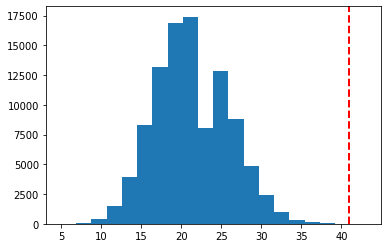

In [101]:
num_bins = 20
plt.hist(sim_scores, num_bins)
plt.axvline(x=high_seed_score, color='r', linestyle='dashed', linewidth=2)
plt.show()